# Time Series Modelling in Finance – Python Tutorial

This notebook accompanies the lecture **"Time Series Modelling in Finance"**.

Goals:

- Make the lecture concepts concrete with Python examples.
- Generate plots you can reuse in slides (prices, returns, ACF/PACF, ARMA fits, etc.).
- Provide hands-on code for students to experiment with.

We will use:

- Synthetic data (so that everything works offline and is reproducible).
- Standard Python libraries: `numpy`, `pandas`, `matplotlib`, `statsmodels`, and optionally `arch` for GARCH.

---

## 0. Setup


In [1]:
# Code cell: imports and basic setup

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

# For nicer plots in notebooks
plt.rcParams["figure.figsize"] = (10, 4)
plt.rcParams["axes.grid"] = True

# Make results reproducible
np.random.seed(42)


---

## 1. What is a Time Series? Simulating a Price Process

We start by simulating a **random walk** as a toy equity price series:

$
P_t = P_{t-1} \cdot e^{r_t}, \quad r_t \sim \mathcal{N}(\mu, \sigma^2),
$

where $ r_t $ is a simple model of log-returns.

This will let us see:

- A non-stationary **price** series.
- A more stationary **log-return** series.

---


In [2]:
# Code cell: simulate a random-walk price series and returns

n_obs = 1000  # number of days
mu = 0.0005   # daily drift
sigma = 0.01  # daily volatility

# Simulate Gaussian log-returns
log_returns = np.random.normal(loc=mu, scale=sigma, size=n_obs)

# Construct price series starting from some initial price
P0 = 100
log_price = np.log(P0) + np.cumsum(log_returns)
prices = np.exp(log_price)

dates = pd.date_range(start="2010-01-01", periods=n_obs, freq="B")  # business days
df = pd.DataFrame({"Price": prices, "LogReturn": log_returns}, index=dates)

df.head()


,Price,LogReturn
2010-01-01,100.548211,0.005467
2010-01-04,100.459502,-0.000883
2010-01-05,101.162848,0.006977
2010-01-06,102.766751,0.015730
2010-01-07,102.577677,-0.001842


---

### 1.1 Plotting Prices vs Log-Returns

We want to visually inspect:

- The **price** series: typically trending and non-stationary.
- The **log-return** series: fluctuating around a roughly constant mean.

---


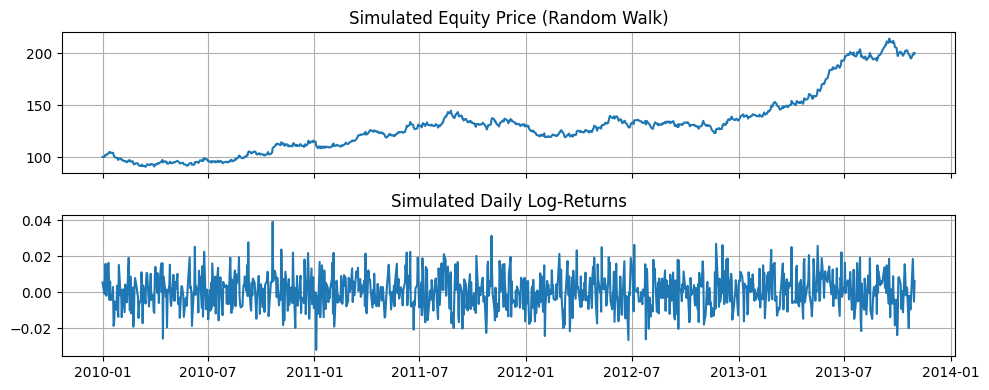

In [3]:
# Code cell: plot price and log-returns

fig, axes = plt.subplots(2, 1, sharex=True)

axes[0].plot(df.index, df["Price"])
axes[0].set_title("Simulated Equity Price (Random Walk)")

axes[1].plot(df.index, df["LogReturn"])
axes[1].set_title("Simulated Daily Log-Returns")

plt.tight_layout()
plt.show()


You should see:

- A price series that drifts upwards (non-stationary).
- Log-returns bouncing around a stable mean with no obvious trend.

These match the discussion in the slides on **prices vs returns** and **stationarity**.

---

## 2. Stationarity and Rolling Statistics

We can inspect stationarity crudely by using **rolling means** and **rolling standard deviations**.

---


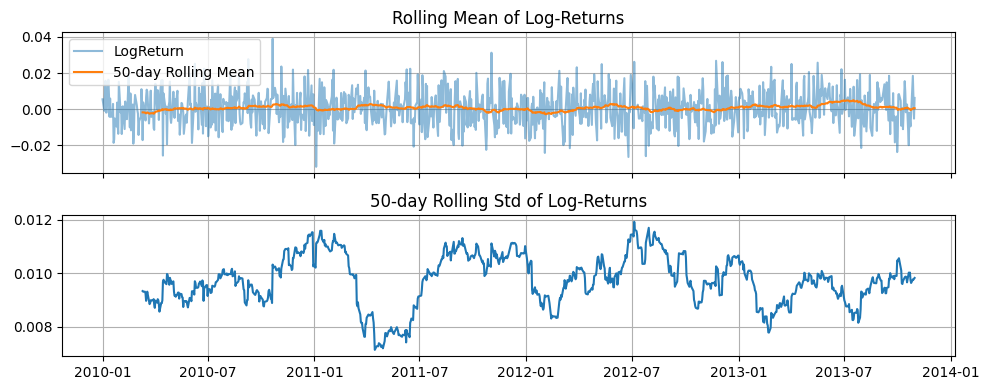

In [4]:
# Code cell: rolling mean and std of log-returns

window = 50  # 50-day rolling window

df["RollMean"] = df["LogReturn"].rolling(window).mean()
df["RollStd"] = df["LogReturn"].rolling(window).std()

fig, axes = plt.subplots(2, 1, sharex=True)

axes[0].plot(df.index, df["LogReturn"], alpha=0.5, label="LogReturn")
axes[0].plot(df.index, df["RollMean"], label=f"{window}-day Rolling Mean")
axes[0].set_title("Rolling Mean of Log-Returns")
axes[0].legend()

axes[1].plot(df.index, df["RollStd"])
axes[1].set_title(f"{window}-day Rolling Std of Log-Returns")

plt.tight_layout()
plt.show()


Interpretation:

- The rolling mean should hover near the theoretical mean `mu`.
- The rolling standard deviation should hover near `sigma`.

While this is synthetic data with constant parameters, real financial data often shows **time-varying volatility** (rolling std changing a lot), which leads to ARCH/GARCH models later.

---

## 3. Distribution of Log-Returns

We now look at the **distribution** of log-returns:

- Histogram
- Comparison to a fitted Normal distribution
- QQ-plot (quantile-quantile plot)

---


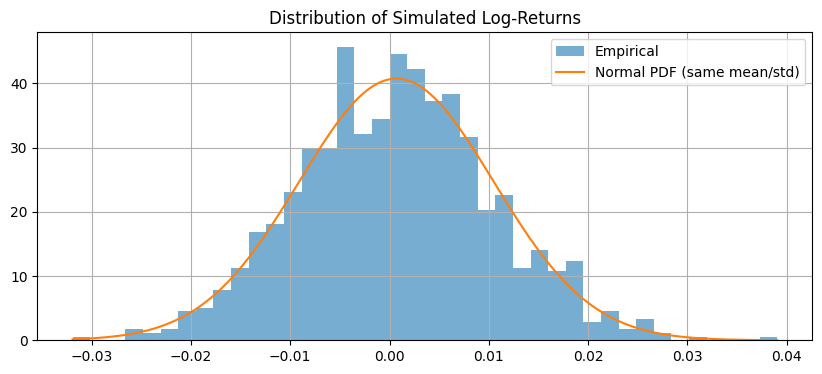

In [5]:
# Code cell: histogram & normal overlay

from scipy.stats import norm

r = df["LogReturn"].dropna()
mean_r, std_r = r.mean(), r.std()

x_vals = np.linspace(r.min(), r.max(), 200)
pdf_vals = norm.pdf(x_vals, loc=mean_r, scale=std_r)

fig, ax = plt.subplots()
ax.hist(r, bins=40, density=True, alpha=0.6, label="Empirical")
ax.plot(x_vals, pdf_vals, label="Normal PDF (same mean/std)")
ax.set_title("Distribution of Simulated Log-Returns")
ax.legend()
plt.show()


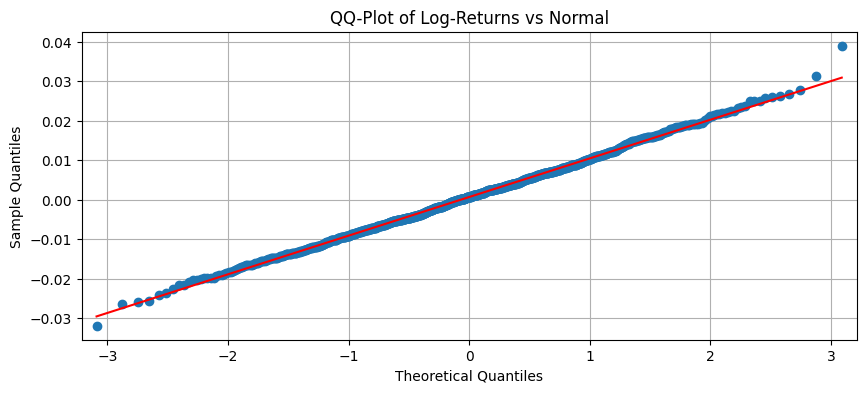

In [6]:
# Code cell: QQ-plot

fig = sm.qqplot(r, line="s")
plt.title("QQ-Plot of Log-Returns vs Normal")
plt.show()


For synthetic Gaussian returns, the histogram and QQ-plot should align well with the Normal assumption.

For real data, you will often see:

- **Fat tails** (departures from the line in the QQ-plot).
- Possible skewness.

These are the “fat tails / leptokurtosis” points from the slides.

---

## 4. Volatility Clustering (Synthetic Example)

To illustrate **volatility clustering**, let’s create a toy series where volatility changes over time:

- First 300 days: low volatility.
- Next 400 days: high volatility.
- Last 300 days: low volatility again.

We’ll keep the mean return the same and only change the standard deviation.

---


In [7]:
# Code cell: piecewise volatility returns

n1, n2, n3 = 300, 400, 300
mu = 0.0005
sigma_low = 0.005
sigma_high = 0.025

r1 = np.random.normal(mu, sigma_low, n1)
r2 = np.random.normal(mu, sigma_high, n2)
r3 = np.random.normal(mu, sigma_low, n3)

r_vol = np.concatenate([r1, r2, r3])

dates_vol = pd.date_range(start="2015-01-01", periods=len(r_vol), freq="B")
df_vol = pd.DataFrame({"LogReturn": r_vol}, index=dates_vol)

df_vol.head()


,LogReturn
2015-01-01,0.007497
2015-01-02,0.005123
2015-01-05,0.000798
2015-01-06,-0.002735
2015-01-07,0.003991


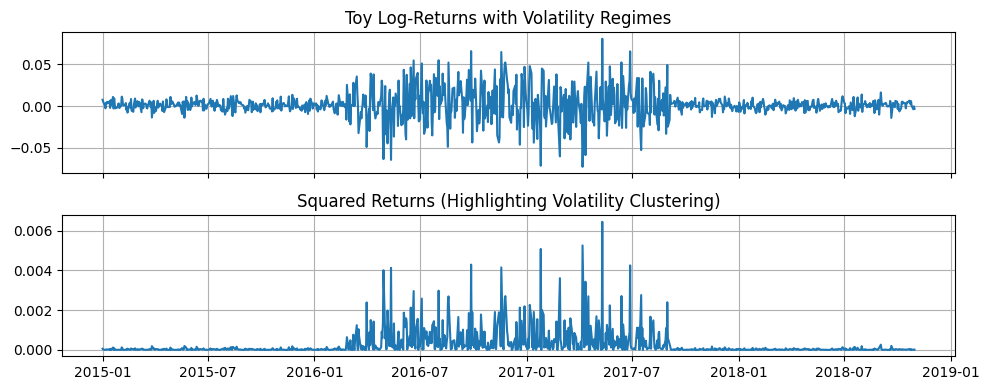

In [8]:
# Code cell: plot returns and squared returns

fig, axes = plt.subplots(2, 1, sharex=True)

axes[0].plot(df_vol.index, df_vol["LogReturn"])
axes[0].set_title("Toy Log-Returns with Volatility Regimes")

axes[1].plot(df_vol.index, df_vol["LogReturn"]**2)
axes[1].set_title("Squared Returns (Highlighting Volatility Clustering)")

plt.tight_layout()
plt.show()


You should see:

- Periods with small fluctuations (low volatility).
- A block of much larger swings (high volatility).
- This is a stylized version of **volatility clustering**.

We can also check the ACF of returns vs squared returns.

---


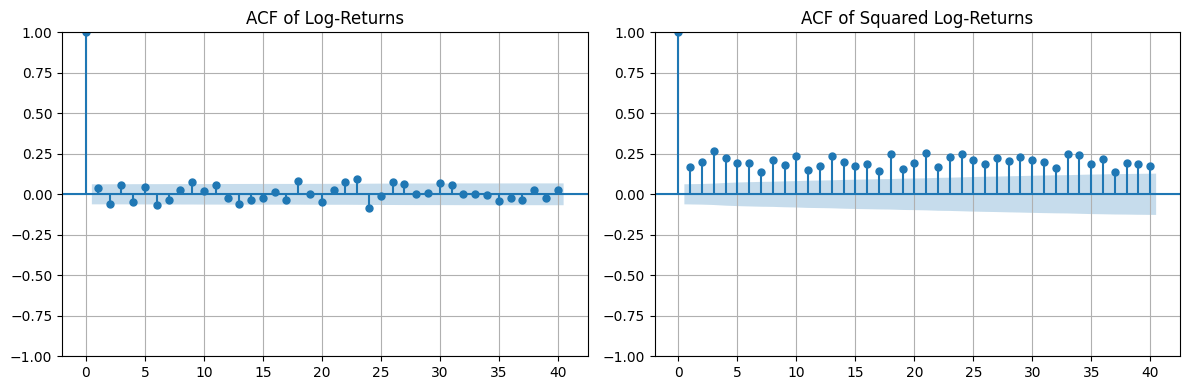

In [9]:
# Code cell: ACF of returns vs squared returns

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

plot_acf(df_vol["LogReturn"], ax=axes[0], lags=40)
axes[0].set_title("ACF of Log-Returns")

plot_acf(df_vol["LogReturn"]**2, ax=axes[1], lags=40)
axes[1].set_title("ACF of Squared Log-Returns")

plt.tight_layout()
plt.show()


Typically:

- ACF of returns: small, quickly decaying correlations (often near zero).
- ACF of squared returns: significantly positive at multiple lags → evidence of volatility clustering.

This matches the “returns vs squared returns” story in the slides.

---

## 5. AR(1) Process – Simulation and Theory

Now we move to **AR(1)** models, which are central in the slides.

Recall:

$
X_t = \phi X_{t-1} + \eta_t, \quad \eta_t \sim \text{white noise}.
$

We’ll:

1. Simulate AR(1) series for different values of \( \phi \).
2. Visualize them.
3. Compare with the theoretical variance formula:
   $
   \sigma_X^2 = \frac{\sigma_\eta^2}{1-\phi^2}.
   $

---


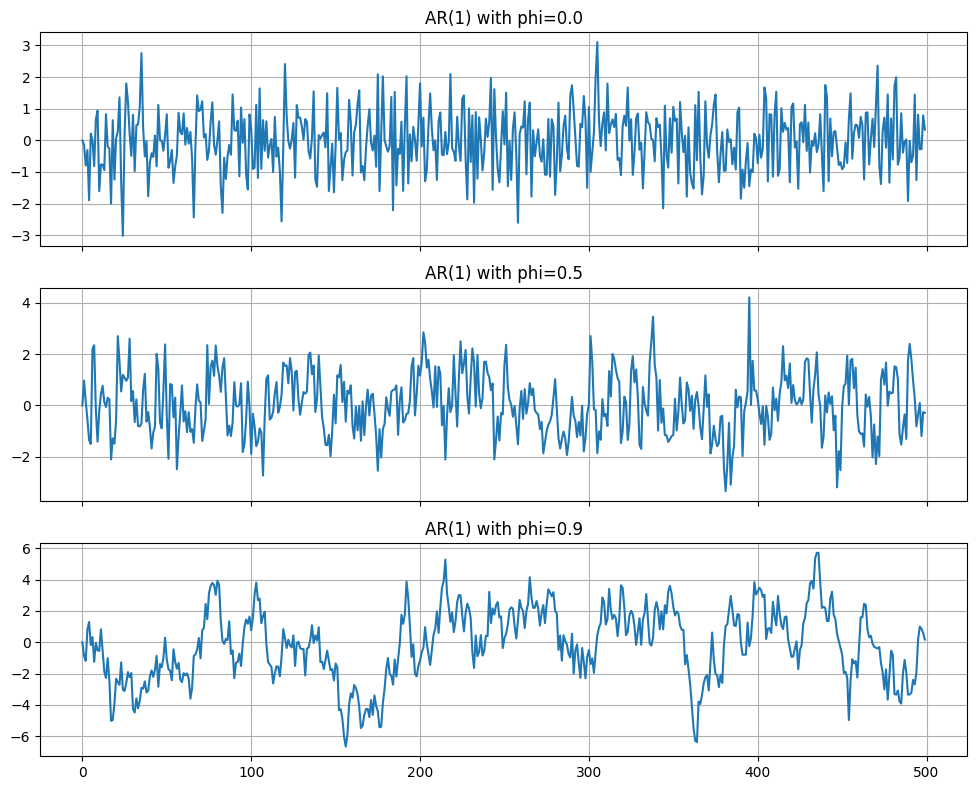

In [10]:
# Code cell: simulate AR(1) process

def simulate_ar1(phi, n=500, sigma_eta=1.0, x0=0.0):
    eta = np.random.normal(0, sigma_eta, size=n)
    x = np.zeros(n)
    x[0] = x0
    for t in range(1, n):
        x[t] = phi * x[t-1] + eta[t]
    return x

phis = [0.0, 0.5, 0.9]
n_ar = 500

fig, axes = plt.subplots(len(phis), 1, sharex=True, figsize=(10, 8))

for i, phi in enumerate(phis):
    x = simulate_ar1(phi, n=n_ar, sigma_eta=1.0)
    axes[i].plot(x)
    axes[i].set_title(f"AR(1) with phi={phi}")

plt.tight_layout()
plt.show()


Interpretation:

- $ \phi = 0.0 $: white noise (no persistence).
- $ \phi = 0.5 $: moderate persistence, series wanders but quickly reverts.
- $ \phi = 0.9 $: high persistence, long swings, very “smooth” behaviour.

Now compare empirical variance with theoretical variance.

---


In [11]:
# Code cell: empirical vs theoretical variance for AR(1)

phi = 0.8
sigma_eta = 1.0
n_ar = 5000

x = simulate_ar1(phi, n=n_ar, sigma_eta=sigma_eta)

empirical_var = np.var(x)
theoretical_var = sigma_eta**2 / (1 - phi**2)

empirical_var, theoretical_var


(np.float64(2.70718001290189), 2.7777777777777786)

You should see that the empirical variance is close to the theoretical value for large `n`.  

This directly illustrates the formula derived in the slides:

$
\mathrm{Var}(X_t) = \frac{\sigma_\eta^2}{1 - \phi^2}.
$

---

### 5.1 ACF of AR(1)

Let’s also look at the ACF of the AR(1) process. For AR(1):

$
\rho(h) = \phi^h.
$

So we expect a **geometrically decaying ACF**.

---


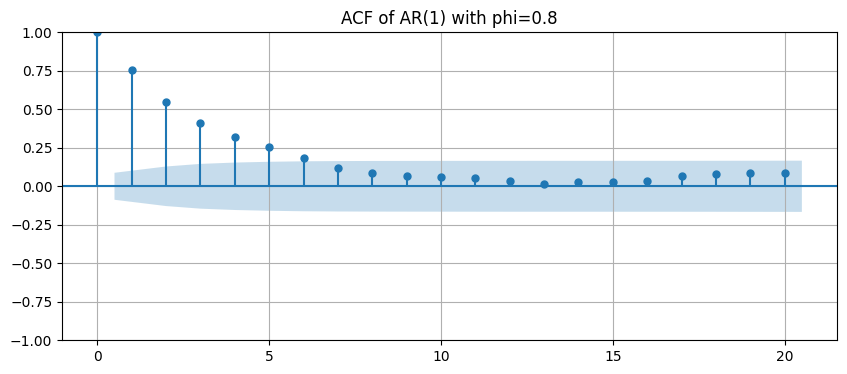

In [12]:
# Code cell: ACF of AR(1)

phi = 0.8
x = simulate_ar1(phi, n=500, sigma_eta=1.0)

fig, ax = plt.subplots()
plot_acf(x, lags=20, ax=ax)
ax.set_title(f"ACF of AR(1) with phi={phi}")
plt.show()


The ACF should clearly decay as powers of $ \phi $.

This connects the AR(1) theory in the slides to a concrete visual example.

---

## 6. ACF and PACF Patterns for AR and MA

To illustrate the **ACF/PACF heuristics**:

- Simulate an **AR(2)** series.
- Simulate an **MA(2)** series.
- Compare their ACF and PACF plots.

---


In [13]:
# Code cell: simulate AR(2) and MA(2)

from statsmodels.tsa.arima_process import ArmaProcess

# AR(2): X_t = 0.75 X_{t-1} - 0.25 X_{t-2} + eta_t
ar_params = np.array([1, -0.75, 0.25])  # note the sign convention for ArmaProcess
ma_params = np.array([1])  # pure AR

ar_process = ArmaProcess(ar=ar_params, ma=ma_params)
ar2_sim = ar_process.generate_sample(nsample=500)

# MA(2): X_t = eta_t + 0.5 eta_{t-1} + 0.3 eta_{t-2}
ar_params_ma = np.array([1])  # pure MA
ma_params_ma = np.array([1, 0.5, 0.3])
ma_process = ArmaProcess(ar=ar_params_ma, ma=ma_params_ma)
ma2_sim = ma_process.generate_sample(nsample=500)


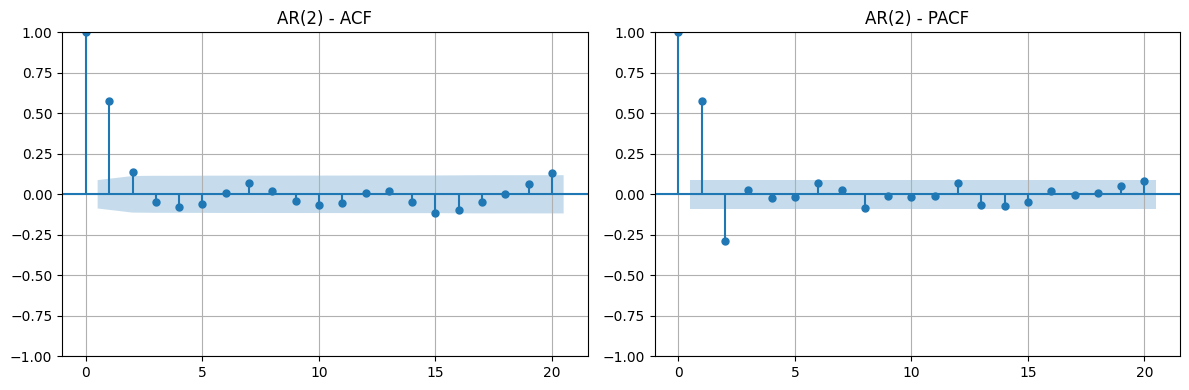

In [14]:
# Code cell: ACF/PACF for AR(2)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

plot_acf(ar2_sim, lags=20, ax=axes[0])
axes[0].set_title("AR(2) - ACF")

plot_pacf(ar2_sim, lags=20, ax=axes[1], method="ywm")
axes[1].set_title("AR(2) - PACF")

plt.tight_layout()
plt.show()


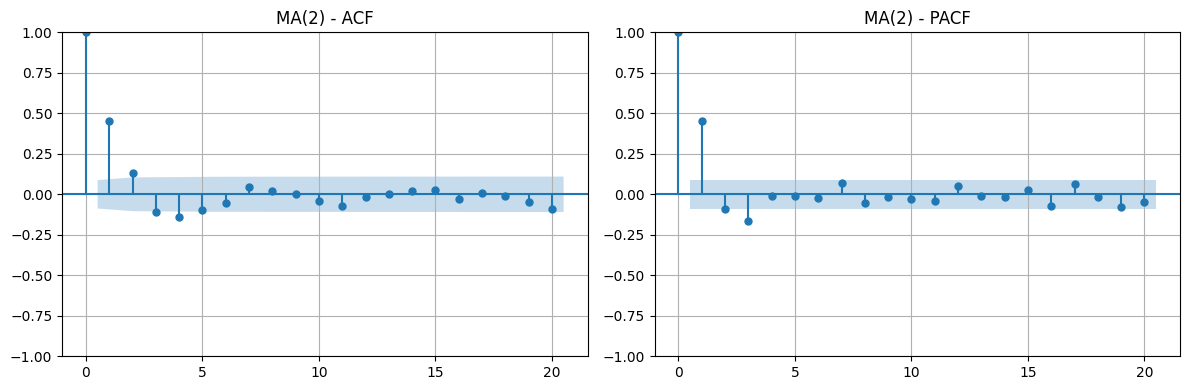

In [15]:
# Code cell: ACF/PACF for MA(2)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

plot_acf(ma2_sim, lags=20, ax=axes[0])
axes[0].set_title("MA(2) - ACF")

plot_pacf(ma2_sim, lags=20, ax=axes[1], method="ywm")
axes[1].set_title("MA(2) - PACF")

plt.tight_layout()
plt.show()


You should observe:

- For **AR(2)**:
  - PACF has significant spikes at lags 1 and 2, then cuts off.
  - ACF decays gradually.
- For **MA(2)**:
  - ACF has significant spikes at lags 1 and 2, then cuts off.
  - PACF decays gradually.

These match the **ACF/PACF heuristics** from the slides.

---

## 7. ARMA Simulation and Wold Intuition

We’ve seen AR and MA separately. Now combine them into a simple ARMA(1,1):

$
X_t = \phi X_{t-1} + \eta_t + \theta \eta_{t-1}.
$

We’ll simulate, plot, and inspect ACF/PACF.

---


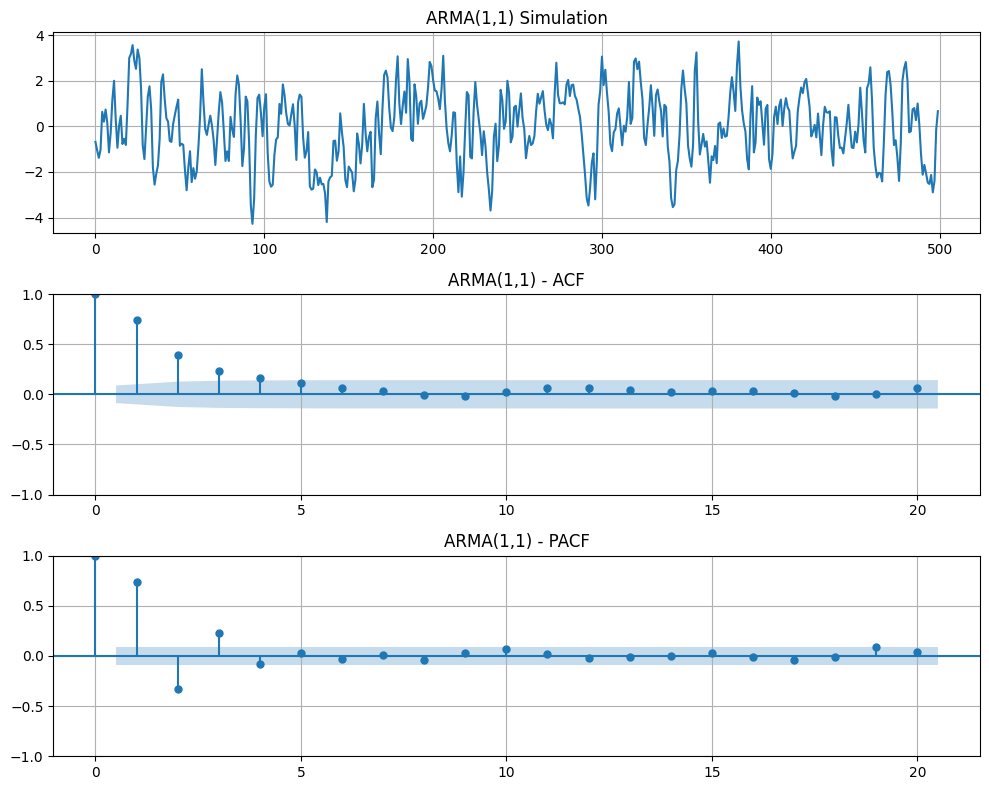

In [16]:
# Code cell: simulate ARMA(1,1)

phi = 0.6
theta = 0.5

arma_process = ArmaProcess(ar=[1, -phi], ma=[1, theta])
arma_sim = arma_process.generate_sample(nsample=500)

fig, axes = plt.subplots(3, 1, figsize=(10, 8))

axes[0].plot(arma_sim)
axes[0].set_title("ARMA(1,1) Simulation")

plot_acf(arma_sim, lags=20, ax=axes[1])
axes[1].set_title("ARMA(1,1) - ACF")

plot_pacf(arma_sim, lags=20, ax=axes[2], method="ywm")
axes[2].set_title("ARMA(1,1) - PACF")

plt.tight_layout()
plt.show()


ACF and PACF now both decay more smoothly, as expected for ARMA models.

The Wold decomposition says any stationary process can be seen as an MA(∞) of shocks. Here, ARMA is a finite parameterization that (implicitly) corresponds to some MA(∞) representation.

---

## 8. Differencing and ARIMA

We now illustrate a simple **non-stationary** series with a trend and how **differencing** makes it stationary.

We’ll construct:

$
Y_t = \beta_0 + \beta_1 t + X_t,
$

with $X_t$ a stationary AR(1) process, then show that $\Delta Y_t$ is more stationary.

---


In [17]:
# Code cell: simulate trend + stationary component

n = 500
beta0 = 10.0
beta1 = 0.05
phi = 0.6

X = simulate_ar1(phi, n=n, sigma_eta=1.0, x0=0.0)
t = np.arange(n)
Y = beta0 + beta1 * t + X

dates_trend = pd.date_range(start="2010-01-01", periods=n, freq="B")
df_trend = pd.DataFrame({"Y": Y}, index=dates_trend)

df_trend.head()


,Y
2010-01-01,10.000000
2010-01-04,11.383998
2010-01-05,11.678134
2010-01-06,11.171566
2010-01-07,10.835440


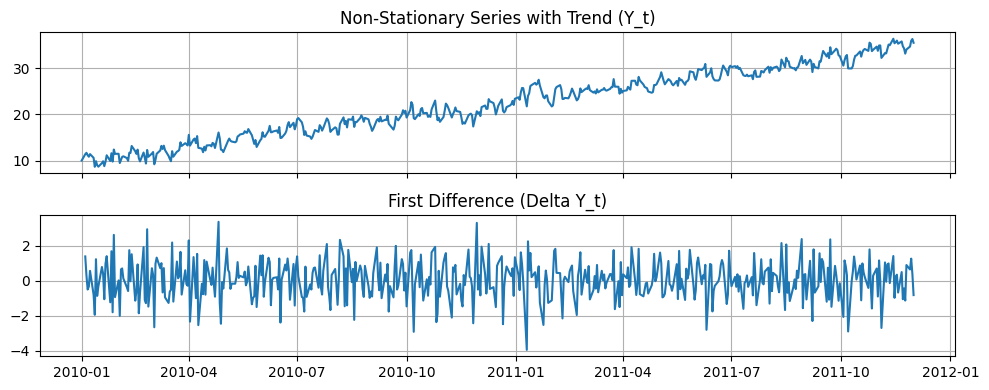

In [18]:
# Code cell: plot Y and its first difference

df_trend["DeltaY"] = df_trend["Y"].diff()

fig, axes = plt.subplots(2, 1, sharex=True)

axes[0].plot(df_trend.index, df_trend["Y"])
axes[0].set_title("Non-Stationary Series with Trend (Y_t)")

axes[1].plot(df_trend.index, df_trend["DeltaY"])
axes[1].set_title("First Difference (Delta Y_t)")

plt.tight_layout()
plt.show()


Visually:

- $Y_t$ has a clear upward trend.
- $\Delta Y_t$ fluctuates around a more stable mean, looking closer to stationary.

We can also compare ACFs.

---


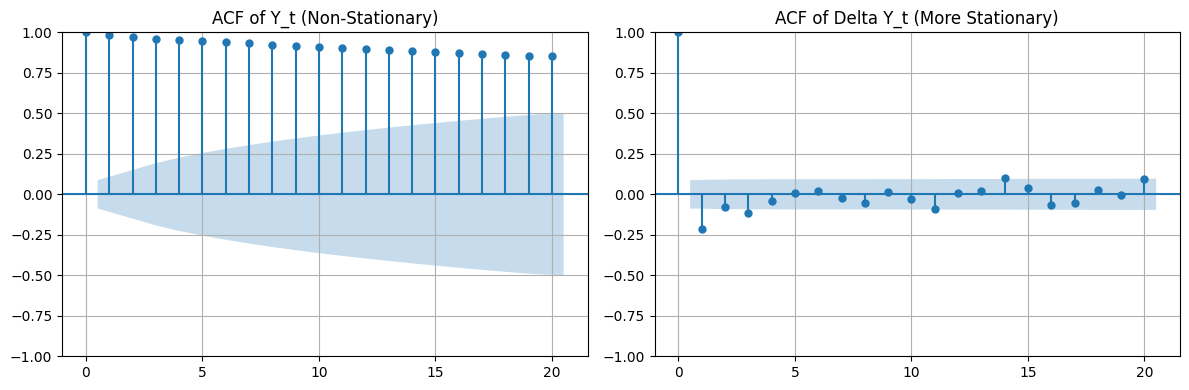

In [19]:
# Code cell: ACF before and after differencing

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

plot_acf(df_trend["Y"].dropna(), lags=20, ax=axes[0])
axes[0].set_title("ACF of Y_t (Non-Stationary)")

plot_acf(df_trend["DeltaY"].dropna(), lags=20, ax=axes[1])
axes[1].set_title("ACF of Delta Y_t (More Stationary)")

plt.tight_layout()
plt.show()


This visually supports the idea:

- ARIMA(p, d, q) = ARMA(p, q) on the differenced series of order `d`.

---

## 9. ARIMA Estimation and Diagnostics

We now **fit** an ARIMA model to the differenced series $\Delta Y_t$.

We know the data-generating process was roughly an AR(1) after differencing, so ARIMA(1,1,0) is a natural candidate.

We will:

1. Fit ARIMA(1,1,0).
2. Examine the summary.
3. Check residual diagnostics.

---


In [ ]:
# Code cell: fit ARIMA(1,1,0)

series = df_trend["Y"]  # non-stationary original

# ARIMA(p, d, q) with d=1
model = ARIMA(series, order=(1, 1, 0))
res = model.fit()

print(res.summary())


                               SARIMAX Results                                
Dep. Variable:                      Y   No. Observations:                  500
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -743.736
Date:                Fri, 12 Dec 2025   AIC                           1491.471
Time:                        10:58:35   BIC                           1499.896
Sample:                    01-01-2010   HQIC                          1494.777
                         - 12-01-2011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2112      0.045     -4.670      0.000      -0.300      -0.123
sigma2         1.1536      0.070     16.580      0.000       1.017       1.290
Ljung-Box (L1) (Q):                   0.44   Jarque-

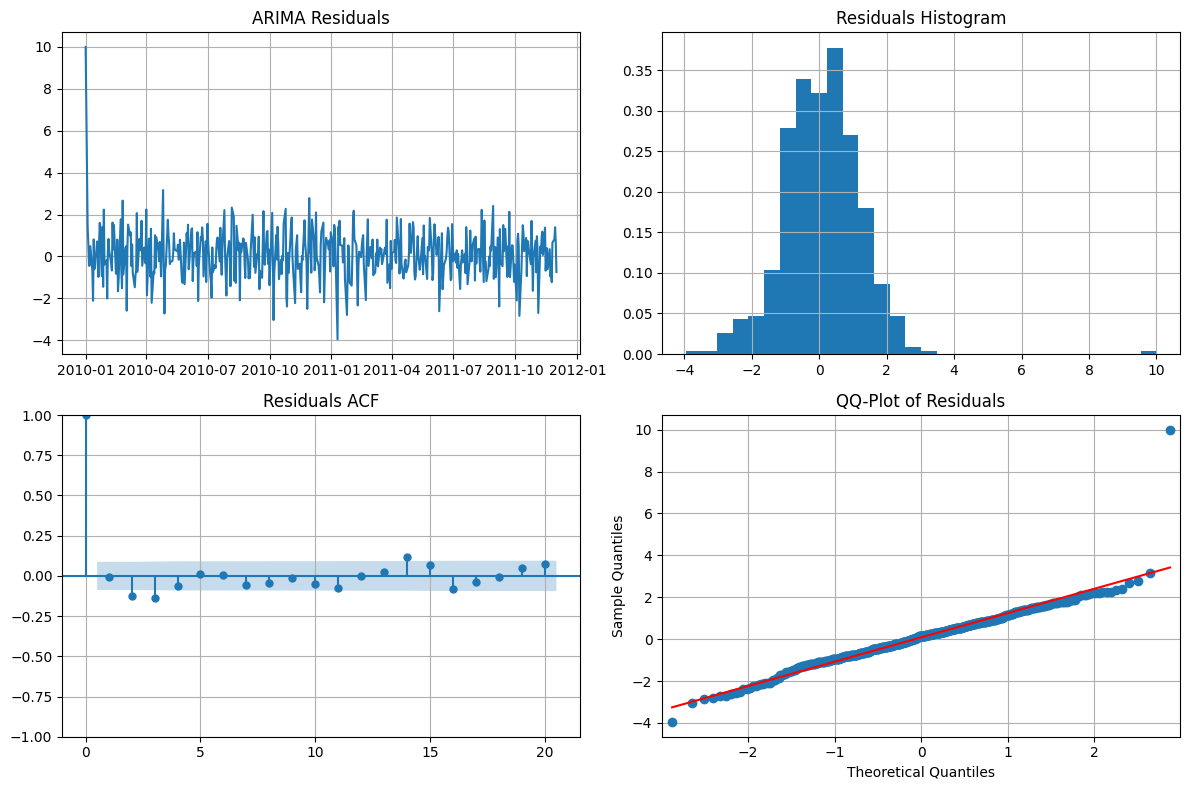

In [21]:
# Code cell: residual diagnostics

residuals = res.resid.dropna()

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Residual time series
axes[0, 0].plot(residuals)
axes[0, 0].set_title("ARIMA Residuals")

# Histogram of residuals
axes[0, 1].hist(residuals, bins=30, density=True)
axes[0, 1].set_title("Residuals Histogram")

# ACF of residuals
plot_acf(residuals, lags=20, ax=axes[1, 0])
axes[1, 0].set_title("Residuals ACF")

# QQ-plot
sm.qqplot(residuals, line="s", ax=axes[1, 1])
axes[1, 1].set_title("QQ-Plot of Residuals")

plt.tight_layout()
plt.show()


In [22]:
# Code cell: Ljung-Box test for residuals

from statsmodels.stats.diagnostic import acorr_ljungbox

lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
lb_test


,lb_stat,lb_pvalue
10,23.47358,0.009127


The Ljung-Box test checks whether the residuals from the ARIMA model are independently distributed (i.e., no significant autocorrelation remains).

If the p-value in the test output is **large** (typically > 0.05), it suggests **no significant autocorrelation** in the residuals—meaning the ARIMA model has adequately captured the time series structure.

If the p-value is **small** (≤ 0.05), it suggests **significant autocorrelation** remains, indicating the model may be inadequate.

Check the `lb_test` output in the previous cell:  
- If the p-value is high, the residuals look like white noise (good fit).
- If the p-value is low, consider a more complex model.

                               SARIMAX Results                                
Dep. Variable:                      Y   No. Observations:                  500
Model:                 ARIMA(2, 2, 0)   Log Likelihood                -850.839
Date:                Sat, 13 Dec 2025   AIC                           1707.677
Time:                        14:21:01   BIC                           1720.309
Sample:                    01-01-2010   HQIC                          1712.635
                         - 12-01-2011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7471      0.040    -18.481      0.000      -0.826      -0.668
ar.L2         -0.3437      0.042     -8.181      0.000      -0.426      -0.261
sigma2         1.7823      0.111     16.048      0.0

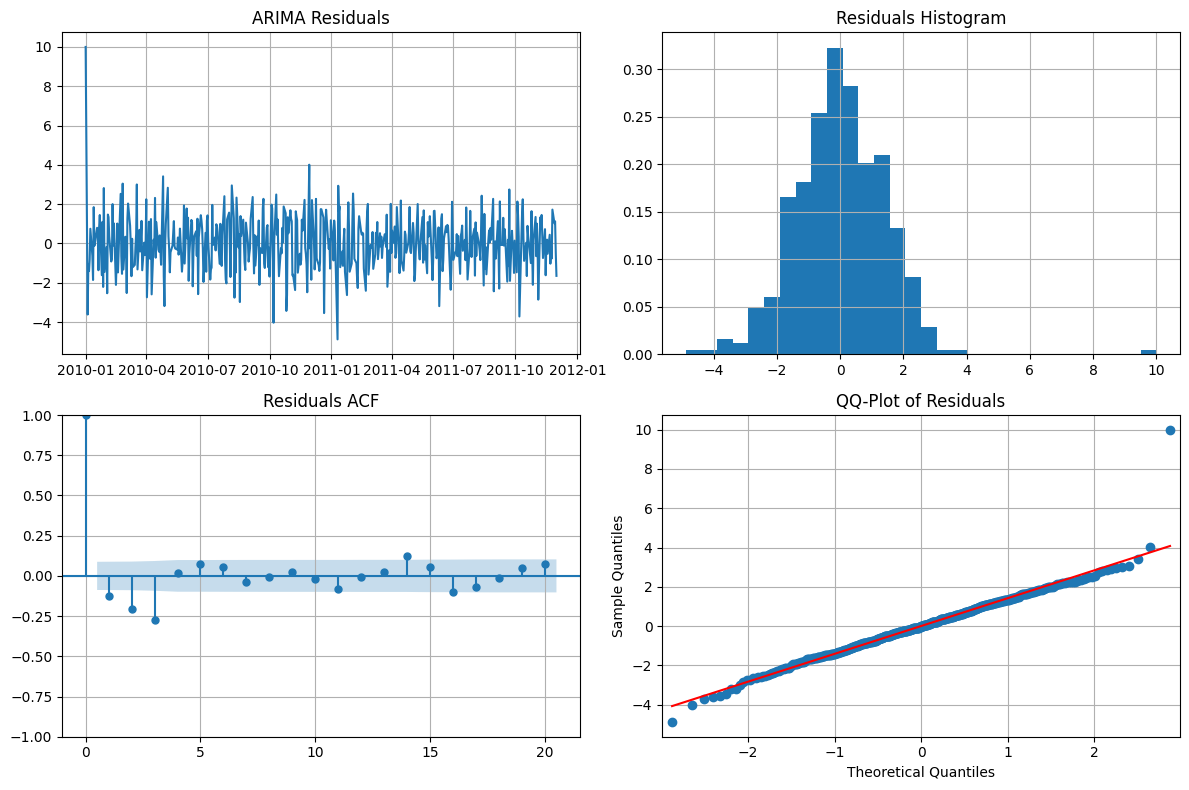

      lb_stat     lb_pvalue
10  71.906765  1.896814e-11


In [30]:
# Code cell: fit ARIMA(1,1,0)

series = df_trend["Y"]  # non-stationary original

# ARIMA(p, d, q) with d=1
model = ARIMA(series, order=(2, 2, 0))
res = model.fit()

print(res.summary())

# Code cell: residual diagnostics

residuals = res.resid.dropna()

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Residual time series
axes[0, 0].plot(residuals)
axes[0, 0].set_title("ARIMA Residuals")

# Histogram of residuals
axes[0, 1].hist(residuals, bins=30, density=True)
axes[0, 1].set_title("Residuals Histogram")

# ACF of residuals
plot_acf(residuals, lags=20, ax=axes[1, 0])
axes[1, 0].set_title("Residuals ACF")

# QQ-plot
sm.qqplot(residuals, line="s", ax=axes[1, 1])
axes[1, 1].set_title("QQ-Plot of Residuals")

plt.tight_layout()
plt.show()

lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print(lb_test)

                               SARIMAX Results                                
Dep. Variable:                      Y   No. Observations:                  500
Model:                 ARIMA(3, 3, 0)   Log Likelihood                -971.855
Date:                Sat, 13 Dec 2025   AIC                           1951.709
Time:                        14:21:15   BIC                           1968.543
Sample:                    01-01-2010   HQIC                          1958.317
                         - 12-01-2011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2502      0.040    -31.275      0.000      -1.328      -1.172
ar.L2         -0.9187      0.056    -16.524      0.000      -1.028      -0.810
ar.L3         -0.4008      0.040     -9.952      0.0

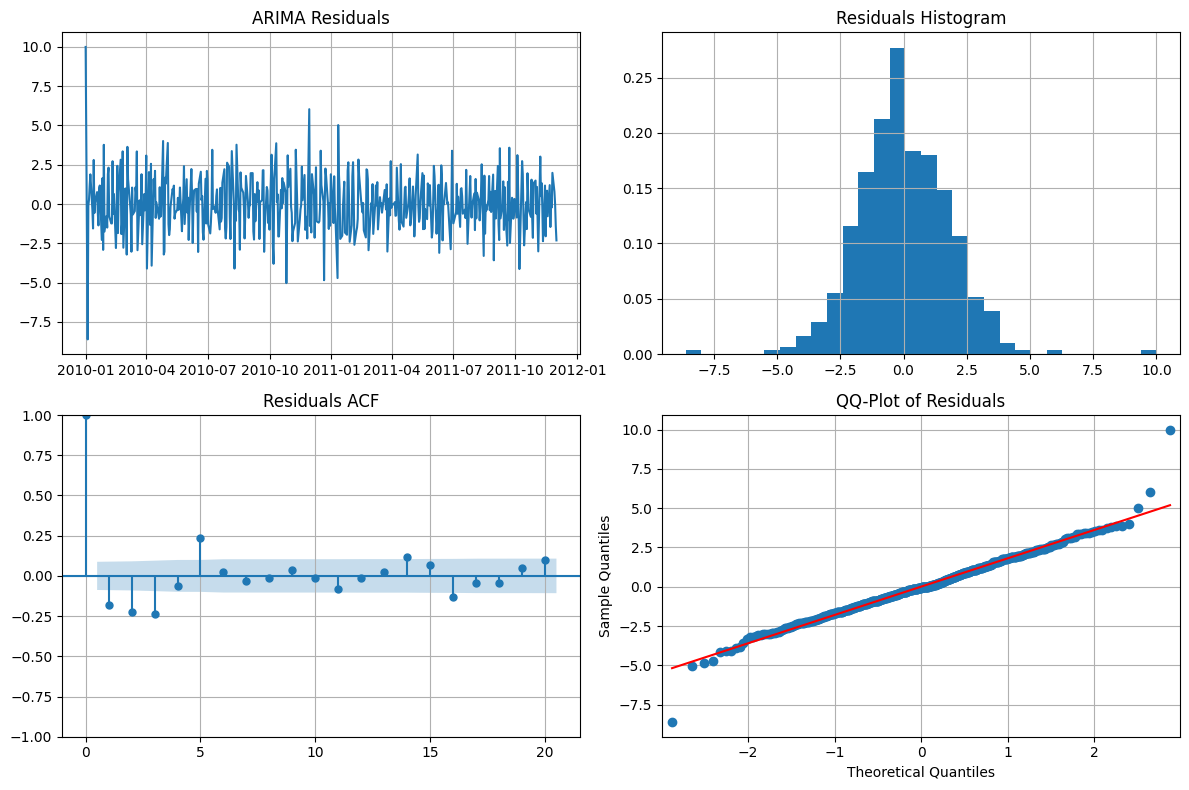

       lb_stat     lb_pvalue
10  101.665684  2.528018e-17


In [31]:
# Code cell: fit ARIMA(1,1,0)

series = df_trend["Y"]  # non-stationary original

# ARIMA(p, d, q) with d=1
model = ARIMA(series, order=(3, 3, 0))
res = model.fit()

print(res.summary())

# Code cell: residual diagnostics

residuals = res.resid.dropna()

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Residual time series
axes[0, 0].plot(residuals)
axes[0, 0].set_title("ARIMA Residuals")

# Histogram of residuals
axes[0, 1].hist(residuals, bins=30, density=True)
axes[0, 1].set_title("Residuals Histogram")

# ACF of residuals
plot_acf(residuals, lags=20, ax=axes[1, 0])
axes[1, 0].set_title("Residuals ACF")

# QQ-plot
sm.qqplot(residuals, line="s", ax=axes[1, 1])
axes[1, 1].set_title("QQ-Plot of Residuals")

plt.tight_layout()
plt.show()

lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print(lb_test)

                               SARIMAX Results                                
Dep. Variable:                      Y   No. Observations:                  500
Model:                 ARIMA(4, 4, 0)   Log Likelihood               -1097.458
Date:                Sat, 13 Dec 2025   AIC                           2204.916
Time:                        14:21:30   BIC                           2225.948
Sample:                    01-01-2010   HQIC                          2213.172
                         - 12-01-2011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7504      0.041    -42.402      0.000      -1.831      -1.669
ar.L2         -1.7300      0.072    -23.909      0.000      -1.872      -1.588
ar.L3         -1.1427      0.074    -15.501      0.0

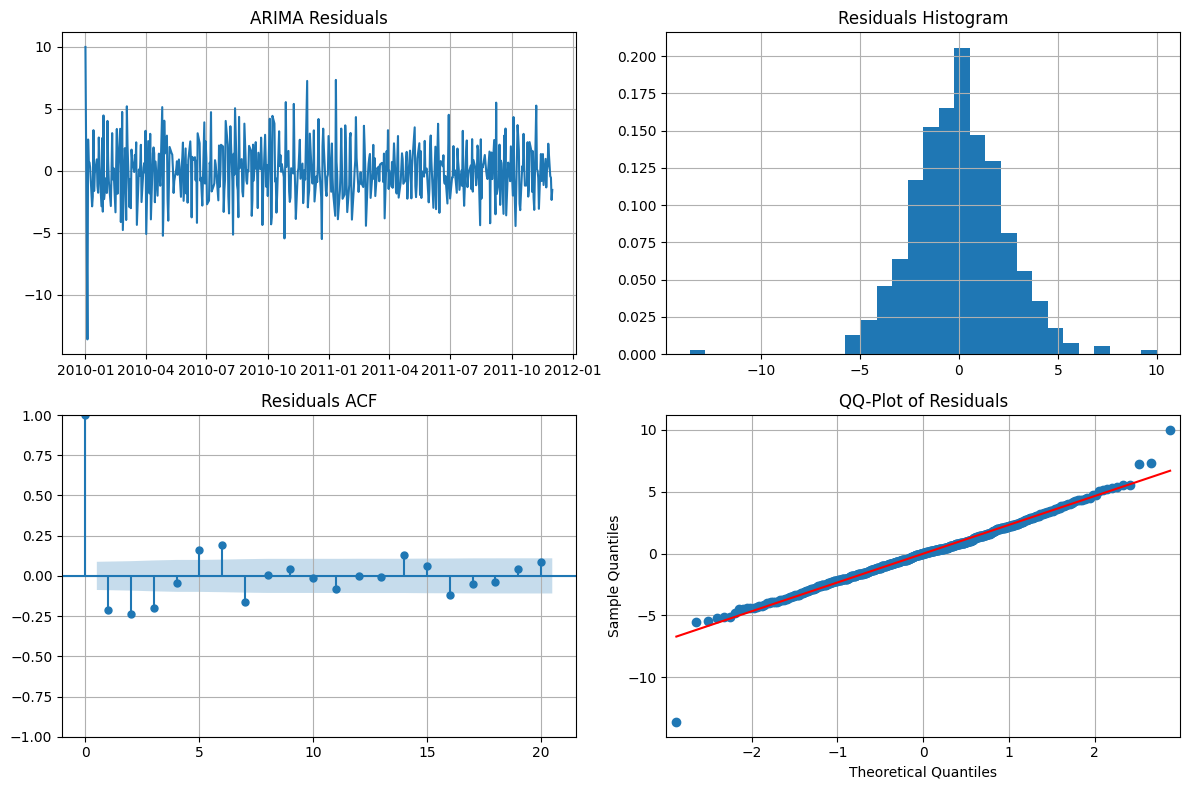

       lb_stat     lb_pvalue
10  118.000071  1.287492e-20


In [32]:
# Code cell: fit ARIMA(1,1,0)

series = df_trend["Y"]  # non-stationary original

# ARIMA(p, d, q) with d=1
model = ARIMA(series, order=(4, 4, 0))
res = model.fit()

print(res.summary())

# Code cell: residual diagnostics

residuals = res.resid.dropna()

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Residual time series
axes[0, 0].plot(residuals)
axes[0, 0].set_title("ARIMA Residuals")

# Histogram of residuals
axes[0, 1].hist(residuals, bins=30, density=True)
axes[0, 1].set_title("Residuals Histogram")

# ACF of residuals
plot_acf(residuals, lags=20, ax=axes[1, 0])
axes[1, 0].set_title("Residuals ACF")

# QQ-plot
sm.qqplot(residuals, line="s", ax=axes[1, 1])
axes[1, 1].set_title("QQ-Plot of Residuals")

plt.tight_layout()
plt.show()

lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print(lb_test)

/Users/hydmbk165294/Library/Python/3.12/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                      Y   No. Observations:                  500
Model:                 ARIMA(5, 5, 2)   Log Likelihood                -916.627
Date:                Sat, 13 Dec 2025   AIC                           1849.254
Time:                        14:22:07   BIC                           1882.890
Sample:                    01-01-2010   HQIC                          1862.458
                         - 12-01-2011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.5196      0.043    -34.949      0.000      -1.605      -1.434
ar.L2         -1.5457      0.076    -20.321      0.000      -1.695      -1.397
ar.L3         -1.2844      0.088    -14.639      0.0

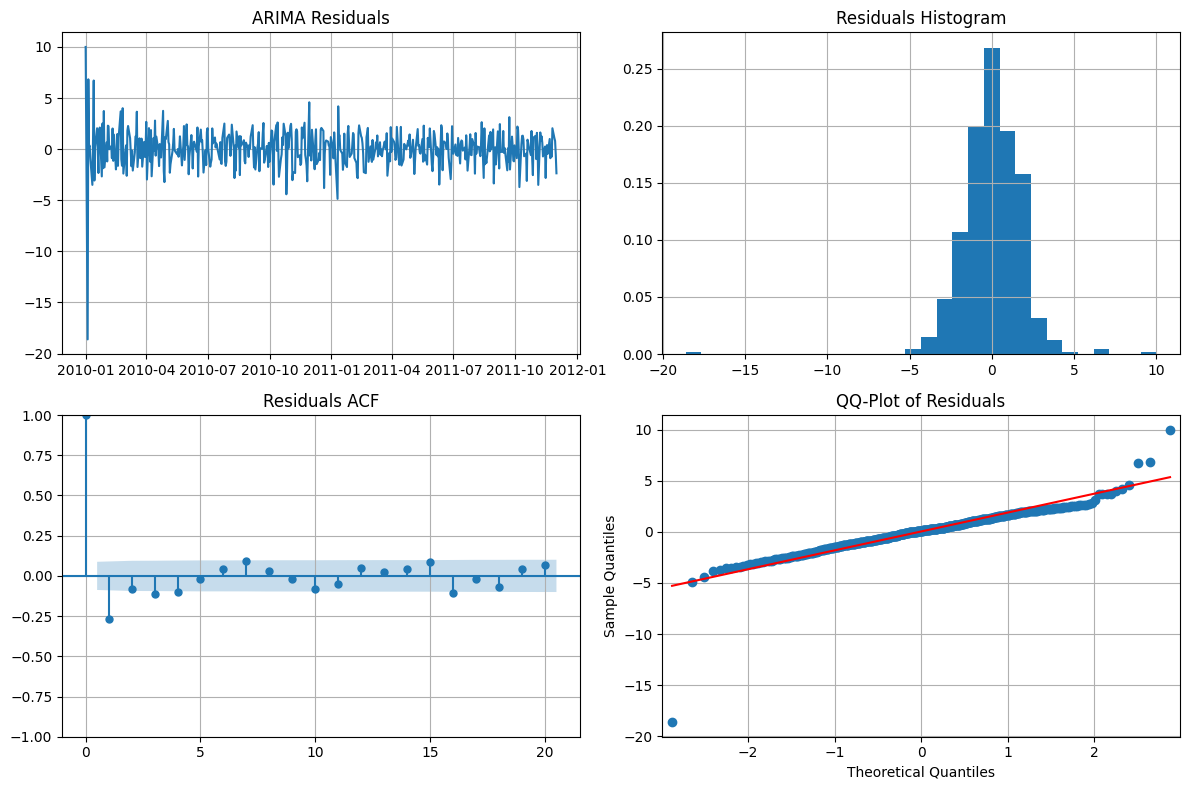

      lb_stat     lb_pvalue
10  61.666248  1.751156e-09


In [33]:
# Code cell: fit ARIMA(1,1,0)

series = df_trend["Y"]  # non-stationary original

# ARIMA(p, d, q) with d=1
model = ARIMA(series, order=(5, 5, 2))
res = model.fit()

print(res.summary())

# Code cell: residual diagnostics

residuals = res.resid.dropna()

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Residual time series
axes[0, 0].plot(residuals)
axes[0, 0].set_title("ARIMA Residuals")

# Histogram of residuals
axes[0, 1].hist(residuals, bins=30, density=True)
axes[0, 1].set_title("Residuals Histogram")

# ACF of residuals
plot_acf(residuals, lags=20, ax=axes[1, 0])
axes[1, 0].set_title("Residuals ACF")

# QQ-plot
sm.qqplot(residuals, line="s", ax=axes[1, 1])
axes[1, 1].set_title("QQ-Plot of Residuals")

plt.tight_layout()
plt.show()

lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print(lb_test)

/Users/hydmbk165294/Library/Python/3.12/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                      Y   No. Observations:                  500
Model:                 ARIMA(6, 6, 3)   Log Likelihood               -1065.347
Date:                Sat, 13 Dec 2025   AIC                           2150.694
Time:                        14:23:21   BIC                           2192.719
Sample:                    01-01-2010   HQIC                          2167.193
                         - 12-01-2011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -2.9089      0.067    -43.267      0.000      -3.041      -2.777
ar.L2         -4.0807      0.160    -25.554      0.000      -4.394      -3.768
ar.L3         -3.9873      0.218    -18.300      0.0

/Users/hydmbk165294/Library/Python/3.12/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


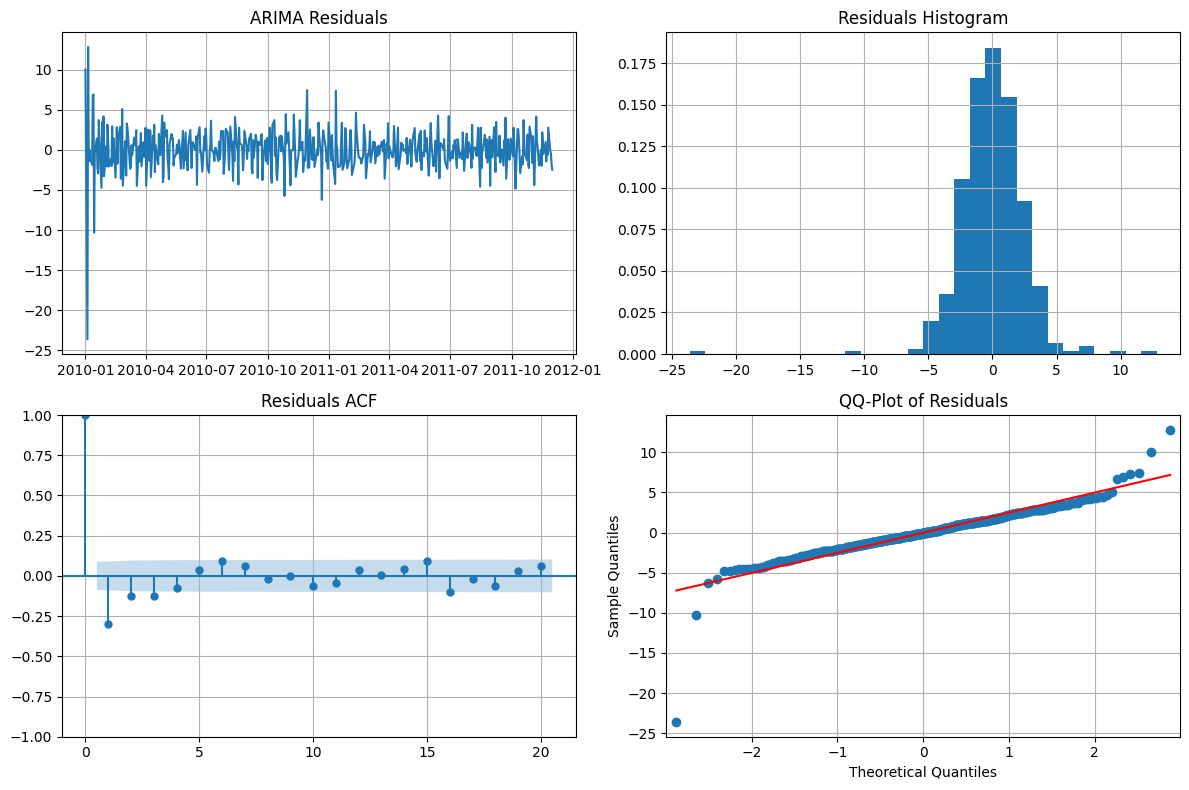

      lb_stat     lb_pvalue
10  73.521328  9.223243e-12


In [34]:
# Code cell: fit ARIMA(1,1,0)

series = df_trend["Y"]  # non-stationary original

# ARIMA(p, d, q) with d=1
model = ARIMA(series, order=(6, 6, 3))
res = model.fit()

print(res.summary())

# Code cell: residual diagnostics

residuals = res.resid.dropna()

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Residual time series
axes[0, 0].plot(residuals)
axes[0, 0].set_title("ARIMA Residuals")

# Histogram of residuals
axes[0, 1].hist(residuals, bins=30, density=True)
axes[0, 1].set_title("Residuals Histogram")

# ACF of residuals
plot_acf(residuals, lags=20, ax=axes[1, 0])
axes[1, 0].set_title("Residuals ACF")

# QQ-plot
sm.qqplot(residuals, line="s", ax=axes[1, 1])
axes[1, 1].set_title("QQ-Plot of Residuals")

plt.tight_layout()
plt.show()

lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print(lb_test)